# Text entailment using BERT model

### Imports

In [ ]:
%pip install -r requirements.txt

In [6]:
import gc
import os
import torch
import random
import wget
import zipfile
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Tuple
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

### Constants

In [7]:
MODEL_VERSION = 1.0
MODEL_VERSION2 = 1.0
MODELS_ROOT_PATH = "./models"
MODEL_PATH = f'{MODELS_ROOT_PATH}/3classes/{MODEL_VERSION}'
MODEL_PATH2 = f'{MODELS_ROOT_PATH}/2classes/{MODEL_VERSION2}'
MODEL_HISTORY_PATH = f'{MODEL_PATH}/history.csv'
MODEL_HISTORY_PATH2 = f'{MODEL_PATH2}/history.csv'

DATASET_URL = 'https://nlp.stanford.edu/projects/snli/snli_1.0.zip'
DATASET_DIR_PATH = './data'
DATASET_NAME = 'snli_1.0'
DATASET_DOWNLOAD_PATH = f'{DATASET_DIR_PATH}/{DATASET_NAME}.zip'

DATA_DEV = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_dev.txt'
DATA_TEST = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_test.txt'
DATA_TRAIN = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_train.txt' 
DATA_TOKENIZE_DEV = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_tokenize_dev_.pkl'
DATA_TOKENIZE_TEST = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_tokenize_test.pkl'
DATA_TOKENIZE_TRAIN = f'{DATASET_DIR_PATH}/{DATASET_NAME}/snli_1.0_tokenize_train.pkl'

MAX_EPOCH = 3
BATCH_SIZE = 32

LABELS = {'neutral': 0, 'contradiction': 1, 'entailment': 2}
LABELS2 = {'neutral': 0, 'contradiction': 0, 'entailment': 1}

## Downalod the SNLI dataset

In [8]:
if not os.path.isdir(DATASET_DIR_PATH):
    os.mkdir(DATASET_DIR_PATH)
    wget.download(DATASET_URL, out=DATASET_DOWNLOAD_PATH)
    
    with zipfile.ZipFile(DATASET_DOWNLOAD_PATH, 'r') as z:
        z.extractall(DATASET_DIR_PATH)
        os.remove(DATASET_DOWNLOAD_PATH)

Select the device for the pytorch

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Load BERT tokenizer

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

## Dataset Preprocessing
1. Load the data from the csv files
2. Clean the data 
    - Remove null
    - Remove rows without gold label ("-" value)
3. Create sequence from the sentences 1 and 2
4. Tokenize the sequence for finding the max sequence token length - later we will padding all the rest of the smaller sequences
5. Find the max sequence tokens length
6. Encode all the sequences with padding by the max length from earlier (getting the input ids and the attention mask)
7. Save the results as pickle for the later use

In [11]:
class snli_preprocessing(object):
    def __init__(self, csv_file: str, save_path: str, tokenizer: BertTokenizer):
        self.data = pd.read_csv(csv_file, sep='\t')
        self.save_path = save_path
        self.tokenizer = tokenizer

    def clean(self):
        self.data = self.data[['gold_label', 'sentence1', 'sentence2']]
        self.data = self.data[self.data['gold_label'] != '-']
        self.data.dropna(inplace=True)

    def tokenize(self):
        self.data['sequence'] = '[CLS]' + self.data['sentence1'] + '[SEP]' + self.data['sentence2'] + '[SEP]'
        self.data['tokens'] = self.data['sequence'].apply(self.tokenizer.tokenize)
        self.data['gold_label_int'] = self.data['gold_label'].apply(lambda l: LABELS[l])

    def max_length(self) -> int:
         # +3 is for [SEP] [SEP] [CLS]
        return len(max(self.data['tokens'], key=len)) + 3

    def encode(self, max_len: int):
        def process(sequence: str, max_len: int):
            return self.tokenizer.encode_plus(
                sequence,
                return_tensors='pt',
                add_special_tokens=True,
                return_attention_mask=True,
                padding='max_length',
                max_length=max_len,
            )

        tokens = self.data['sequence'].apply(lambda seq: process(seq, max_len))
        self.data[['input_ids', 'token_type_ids', 'attention_mask']] = tokens.apply(pd.Series)
        self.data.drop(['tokens'], axis=1, inplace=True)

    def save(self):
        self.data.to_pickle(self.save_path)

In [12]:
if not os.path.isfile(DATA_TOKENIZE_TRAIN) and not os.path.isfile(DATA_TOKENIZE_DEV) and not os.path.isfile(DATA_TOKENIZE_TEST):
    print('Tokenize the dataset')

    train = snli_preprocessing(csv_file=DATA_TRAIN, save_path=DATA_TOKENIZE_TRAIN, tokenizer=tokenizer)
    dev = snli_preprocessing(csv_file=DATA_DEV, save_path=DATA_TOKENIZE_DEV, tokenizer=tokenizer)
    test = snli_preprocessing(csv_file=DATA_TEST, save_path=DATA_TOKENIZE_TEST, tokenizer=tokenizer)

    max_len = 0
    dataset = [train, dev, test]

    for data in dataset:
        data.clean()

        # basic tokenize to find the max sentences length
        data.tokenize() 

        data_max_len = data.max_length()
        max_len = data_max_len if data_max_len > max_len else max_len

    # encode after find the max sentences length in the dataset
    for data in dataset:
        data.encode(max_len)
        data.save()

    train, dev, test = train.data, dev.data, test.data

    print(f'Max length: {max_len}')

else:   
    print('The dataset already tokenized, Loading pickles...')
    
    train = pd.read_pickle(DATA_TOKENIZE_TRAIN)
    dev = pd.read_pickle(DATA_TOKENIZE_DEV)
    test = pd.read_pickle(DATA_TOKENIZE_TEST)


The dataset already tokenized, Loading pickles...


In [13]:
def create_tensor_dataset(dataset: pd.DataFrame):
    input_ids = torch.cat(tuple(dataset['input_ids'].values))
    attention_mask = torch.cat(tuple(dataset['attention_mask'].values))
    labels = torch.tensor(dataset['gold_label_int'].values)

    return TensorDataset(input_ids, attention_mask, labels)

In [14]:
train_tensor = create_tensor_dataset(train)
dev_tensor = create_tensor_dataset(dev)
test_tensor = create_tensor_dataset(test)

In [15]:
train_loader = DataLoader(train_tensor, batch_size=BATCH_SIZE, sampler=RandomSampler(train_tensor))
dev_loader = DataLoader(dev_tensor, batch_size=BATCH_SIZE, sampler=SequentialSampler(dev_tensor))
test_loader = DataLoader(test_tensor, batch_size=BATCH_SIZE)

# BERT Model for sequence classification
### 3-Way Classification

In [16]:
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3, output_attentions=False, output_hidden_states=False)
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Set the seed value to make this reproducible

In [17]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [18]:
class Train(object):
    def __init__(self, 
        model: BertForSequenceClassification, 
        train: DataLoader, 
        eval: DataLoader, 
        epoch: int,
        model_save_path: str,
        history_save_path: str
    ):
        self.train_loader = train
        self.eval_loader = eval
        self.epoch = epoch
        self.history = []
        self.model = model
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5)
        self.model_save_path = model_save_path
        self.history_save_path = history_save_path

        self.process()


    def accuracy(self, predictions: torch.Tensor, labels: torch.Tensor) -> float:
        predictions = torch.argmax(predictions, axis=1)
        accuracy = torch.sum(predictions == labels) / len(labels)
        return accuracy.item()
        

    def train(self) -> Tuple[float, float]:
        train_bar = tqdm(total=len(self.train_loader), position=1, desc="Training")
        total_loss = 0
        total_accuracy = 0

        self.model.train()  

        for batch in self.train_loader:
            batch_ids = batch[0].to(device)
            batch_masks = batch[1].to(device)
            batch_labels = batch[2].to(device)

            self.model.zero_grad()

            output = self.model(batch_ids, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
            loss = output.loss

            total_loss += loss.item()
            total_accuracy += self.accuracy(output.logits, batch_labels)

            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            self.optimizer.step()
            train_bar.update(1)
            train_bar.set_postfix({
                'loss': total_loss / len(self.train_loader),
                'acc': total_accuracy / len(self.train_loader)
            })

        avg_loss = total_loss / len(self.train_loader)
        avg_accuracy = total_accuracy / len(self.train_loader)

        return avg_loss, avg_accuracy


    def eval(self) -> Tuple[float, float]:
        eval_bar = tqdm(total=len(self.eval_loader), position=0, desc="Validation")
        
        total_loss = 0
        total_accuracy = 0

        self.model.eval()

        for batch in self.eval_loader:
            batch_ids = batch[0].to(device)
            batch_masks = batch[1].to(device)
            batch_labels = batch[2].to(device)

            with torch.no_grad():
                output = self.model(batch_ids, token_type_ids=None, attention_mask=batch_masks, labels=batch_labels)
        
            total_loss += output.loss.item()
            total_accuracy += self.accuracy(output.logits, batch_labels)

            eval_bar.update(1)
            eval_bar.set_postfix({
                'loss': total_loss / len(self.eval_loader), 
                'acc': total_accuracy / len(self.eval_loader)
            })

        avg_loss = total_loss / len(self.eval_loader)
        avg_accuracy = total_accuracy / len(self.eval_loader)

        return avg_loss, avg_accuracy


    @staticmethod
    def test(model: BertForSequenceClassification, loader: DataLoader) -> Tuple[np.array, np.array]:
        model.eval()
        predictions, labels = [], []
        test_bar = tqdm(total=len(loader), desc="Testing")

        for batch in loader:
            batch_ids = batch[0].to(device)
            batch_masks = batch[1].to(device)
            batch_labels = batch[2].to(device)

            with torch.no_grad():
                output = model(batch_ids, token_type_ids=None, attention_mask=batch_masks)

            predictions.append(torch.argmax(output.logits, axis=1))
            labels.append(batch_labels)

            test_bar.update(1)


        predictions = torch.cat(predictions).cpu().numpy()
        labels = torch.cat(labels).cpu().numpy()

        return predictions, labels


    def save(self):
        self.model.save_pretrained(self.model_save_path)
        pd.DataFrame(self.history).set_index('epoch').to_csv(self.history_save_path)


    def process(self):
        for epoch in range(self.epoch):
            print(f'Epoch {epoch + 1}/{self.epoch}')

            train_loss, train_acc = self.train()
            eval_loss, eval_acc = self.eval()

            self.history.append({
                'epoch': epoch,
                'training_loss': train_loss,
                'training_accuracy': train_acc,
                'validation_loss': eval_loss,
                'validation_accuracy': eval_acc
            })

            self.save()

### Training

In [19]:
if not os.path.isdir(MODEL_PATH):
    Train(
        model=model,
        train=train_loader,
        eval=dev_loader,
        epoch=MAX_EPOCH,
        model_save_path=MODEL_PATH,
        history_save_path=MODEL_HISTORY_PATH
    )
    
else:
    print(f'Model version {MODEL_VERSION} already exists')

Model version 1.0 already exists


### Testing

In [20]:
l_model = BertForSequenceClassification.from_pretrained(MODEL_PATH)
l_model.to(device)

predictions, labels = Train.test(model=l_model, loader=test_loader)

Testing: 100%|██████████| 307/307 [00:38<00:00,  8.00it/s]


### Classification Report
Including f1 score

In [21]:
print(classification_report(predictions, labels, labels=np.unique(labels), zero_division=0))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      3229
           1       0.95      0.89      0.92      3437
           2       0.88      0.94      0.90      3158

    accuracy                           0.89      9824
   macro avg       0.89      0.89      0.89      9824
weighted avg       0.90      0.89      0.89      9824



### History & Overfitting test

In [22]:
history = pd.read_csv(MODEL_HISTORY_PATH)
history

,epoch,training_loss,training_accuracy,validation_loss,validation_accuracy
0,0,0.412927,0.842313,0.298896,0.890794
1,1,0.292383,0.894614,0.277398,0.901019
2,2,0.232486,0.918586,0.325372,0.892925


In [23]:
def plot_accuracy_and_loss_graphs(history: pd.DataFrame):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history['training_accuracy'])
    plt.plot(history['validation_accuracy'])
    plt.title("Accuracy")
    plt.xlabel('epoch')
    plt.xticks(range(MAX_EPOCH))
    plt.ylabel('accuracy')
    plt.legend(['train','validation'])

    plt.subplot(1,2,2)
    plt.plot(history['training_loss'])
    plt.plot(history['validation_loss'])
    plt.title("Loss")
    plt.xlabel('epoch')
    plt.xticks(range(MAX_EPOCH))
    plt.ylabel('loss')
    plt.legend(['train','validation'])

    plt.show()

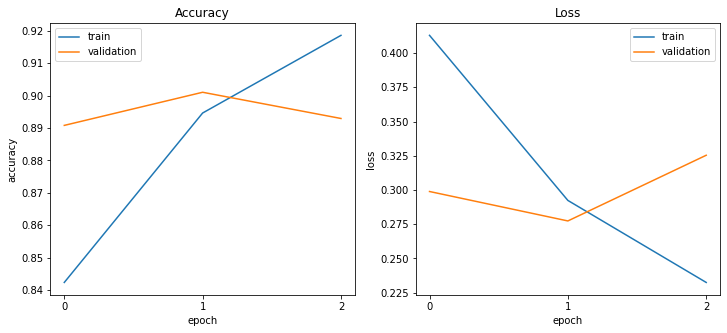

In [24]:
plot_accuracy_and_loss_graphs(history)

# BERT Model for sequence classification
### 2-Way Classification

In [25]:
gc.collect()

6130

In [26]:
train2 = train.copy()
dev2 = dev.copy()
test2 = test.copy()

Transform the dataset labels from 3 classes to 2

In [27]:
def binary_classification(label: str) -> int:
    return LABELS2[label]

train2['gold_label_int'] = train2['gold_label'].apply(binary_classification)
dev2['gold_label_int'] = dev2['gold_label'].apply(binary_classification)
test2['gold_label_int'] = test2['gold_label'].apply(binary_classification)

In [28]:
train_tensor2 = create_tensor_dataset(train2)
dev_tensor2 = create_tensor_dataset(dev2)
test_tensor2 = create_tensor_dataset(test2)

In [29]:
train_loader2 = DataLoader(train_tensor2, batch_size=BATCH_SIZE, sampler=RandomSampler(train_tensor2))
dev_loader2 = DataLoader(dev_tensor2, batch_size=BATCH_SIZE, sampler=SequentialSampler(dev_tensor2))
test_loader2 = DataLoader(test_tensor2, batch_size=BATCH_SIZE)

In [30]:
model2 = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2, output_attentions=False, output_hidden_states=False)
model2.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Training

In [31]:
if not os.path.isdir(MODEL_PATH2):
    Train(
        model=model2,
        train=train_loader2,
        eval=dev_loader2,
        epoch=MAX_EPOCH,
        model_save_path=MODEL_PATH2,
        history_save_path=MODEL_HISTORY_PATH2
    )
    
else:
    print(f'Model version {MODEL_VERSION2} already exists')

Model version 1.0 already exists


### Testing

In [32]:
l_model2 = BertForSequenceClassification.from_pretrained(MODEL_PATH2)
l_model2.to(device)

predictions2, labels2 = Train.test(model=l_model2, loader=test_loader2)

Testing: 100%|██████████| 307/307 [00:37<00:00,  8.17it/s]


### Classification reports
f1 score included

In [33]:
print(classification_report(predictions2, labels2, labels=np.unique(labels2), zero_division=0))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      6553
           1       0.89      0.92      0.90      3271

    accuracy                           0.93      9824
   macro avg       0.92      0.93      0.93      9824
weighted avg       0.93      0.93      0.93      9824



### History & Overfitting test

In [34]:
history2 = pd.read_csv(MODEL_HISTORY_PATH2)
history2

,epoch,training_loss,training_accuracy,validation_loss,validation_accuracy
0,0,0.234071,0.907563,0.172214,0.932776
1,1,0.174190,0.934723,0.162952,0.943328
2,2,0.138535,0.949514,0.168336,0.938966


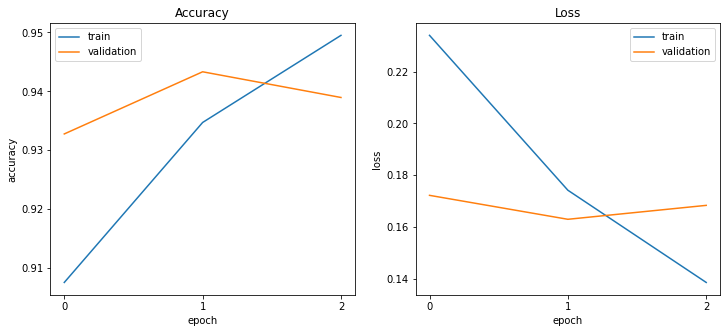

In [35]:
plot_accuracy_and_loss_graphs(history2)

In [36]:
test

,gold_label,sentence1,sentence2,sequence,gold_label_int,input_ids,token_type_ids,attention_mask
0,neutral,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,[CLS]This church choir sings to the masses as ...,0,"[[tensor(101), tensor(101), tensor(1188), tens...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
1,entailment,This church choir sings to the masses as they ...,The church is filled with song.,[CLS]This church choir sings to the masses as ...,2,"[[tensor(101), tensor(101), tensor(1188), tens...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
2,contradiction,This church choir sings to the masses as they ...,A choir singing at a baseball game.,[CLS]This church choir sings to the masses as ...,1,"[[tensor(101), tensor(101), tensor(1188), tens...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
3,neutral,"A woman with a green headscarf, blue shirt and...",The woman is young.,"[CLS]A woman with a green headscarf, blue shir...",0,"[[tensor(101), tensor(101), tensor(138), tenso...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
4,entailment,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,"[CLS]A woman with a green headscarf, blue shir...",2,"[[tensor(101), tensor(101), tensor(138), tenso...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
...,...,...,...,...,...,...,...,...
9995,contradiction,Two women are observing something together.,Two women are standing with their eyes closed.,[CLS]Two women are observing something togethe...,1,"[[tensor(101), tensor(101), tensor(1960), tens...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
9996,entailment,Two women are observing something together.,Two girls are looking at something.,[CLS]Two women are observing something togethe...,2,"[[tensor(101), tensor(101), tensor(1960), tens...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
9997,contradiction,A man in a black leather jacket and a book in ...,A man is flying a kite.,[CLS]A man in a black leather jacket and a boo...,1,"[[tensor(101), tensor(101), tensor(138), tenso...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
9998,entailment,A man in a black leather jacket and a book in ...,A man is speaking in a classroom.,[CLS]A man in a black leather jacket and a boo...,2,"[[tensor(101), tensor(101), tensor(138), tenso...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


## Error Analysis

In [37]:
raw_test_set = pd.read_csv(DATA_TEST, sep='\t')
raw_test_set = raw_test_set[raw_test_set['gold_label'] != '-']
raw_test_set.dropna(inplace=True, subset=["gold_label", "sentence1", "sentence2"], how='all')
raw_test_set.describe()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
count,9824,9824,9824,9824,9824,9824,9824,9824,9824,9824,9824,9824,9824,9815
unique,3,3323,9639,3323,9639,3323,9639,3323,9824,3,3,3,3,3
top,entailment,( ( ( A boy ) ( in ( a ( yellow ( ( ( t-shirt ...,( ( The man ) ( ( is outside ) . ) ),(ROOT (S (NP (NP (DT A) (NN boy)) (PP (IN in) ...,(ROOT (S (NP (DT The) (NN man)) (VP (VBZ is) (...,A boy in a yellow t-shirt and pink sweater tal...,The man is outside.,4876043682.jpg#0,2677109430.jpg#1r1n,entailment,entailment,entailment,entailment,entailment
freq,3368,6,7,6,7,6,7,6,1,3281,3346,3373,3491,3482


In [38]:
def count_labels(row, labels):
    result = [0, 0, 0]
    for i in range(1,6):
        if not pd.isna(row[f"label{i}"]):
            result[labels.get(row[f"label{i}"])] += 1
    return max(result)


raw_test_set["predictions_3_way"] = predictions
raw_test_set["predictions_2_way"] = predictions2
raw_test_set["gold_label_3_way"] = test["gold_label_int"]
raw_test_set["gold_label_2_way"] = test2["gold_label_int"]
raw_test_set["sentence1_len"] = test["sentence1"].apply(lambda val: len(val.split(" ")))
raw_test_set["sentence2_len"] = test["sentence2"].apply(lambda val: len(val.split(" ")))


raw_test_set["won_by_3_way"] = raw_test_set.apply(lambda row: count_labels(row, LABELS), axis=1)
raw_test_set["won_by_2_way"] = raw_test_set.apply(lambda row: count_labels(row, LABELS2), axis=1)
raw_test_set["correct_pred_3_way"] = raw_test_set.apply(lambda row: row["predictions_3_way"] == row["gold_label_3_way"], axis=1)
raw_test_set["correct_pred_2_way"] = raw_test_set.apply(lambda row: row["predictions_2_way"] == row["gold_label_2_way"], axis=1)
raw_test_set.head(3)

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,...,predictions_3_way,predictions_2_way,gold_label_3_way,gold_label_2_way,sentence1_len,sentence2_len,won_by_3_way,won_by_2_way,correct_pred_3_way,correct_pred_2_way
0,neutral,( ( This ( church choir ) ) ( ( ( sings ( to (...,( ( The church ) ( ( has ( cracks ( in ( the c...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,(ROOT (S (NP (DT The) (NN church)) (VP (VBZ ha...,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,2677109430.jpg#1,2677109430.jpg#1r1n,neutral,...,1,0,0,0,18,7,3,5,False,True
1,entailment,( ( This ( church choir ) ) ( ( ( sings ( to (...,( ( The church ) ( ( is ( filled ( with song )...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,(ROOT (S (NP (DT The) (NN church)) (VP (VBZ is...,This church choir sings to the masses as they ...,The church is filled with song.,2677109430.jpg#1,2677109430.jpg#1r1e,entailment,...,2,1,2,1,18,6,4,4,True,True
2,contradiction,( ( This ( church choir ) ) ( ( ( sings ( to (...,( ( ( A choir ) ( singing ( at ( a ( baseball ...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,(ROOT (NP (NP (DT A) (NN choir)) (VP (VBG sing...,This church choir sings to the masses as they ...,A choir singing at a baseball game.,2677109430.jpg#1,2677109430.jpg#1r1c,contradiction,...,1,0,1,0,18,7,5,5,True,True


In [39]:
errors3 = raw_test_set[raw_test_set["predictions_3_way"] != raw_test_set["gold_label_3_way"]]
errors2 = raw_test_set[raw_test_set["predictions_2_way"] != raw_test_set["gold_label_2_way"]]
print(f"Wrong predictions 3-way: {len(errors3)} ({(len(errors3) / len(raw_test_set)) * 100:.3f}%)")
print(f"Wrong predictions 2-way: {len(errors2)} ({(len(errors2) / len(raw_test_set)) * 100:.2f}%)")



Wrong predictions 3-way: 1040 (10.586%)
Wrong predictions 2-way: 651 (6.63%)


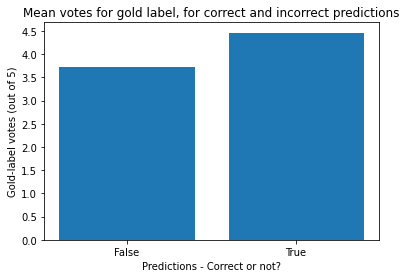

,won_by_3_way
correct_pred_3_way,
False,3.729808
True,4.463001


In [40]:
def plot_votes_correctness(test_set, num_of_classes):
    result = test_set.groupby([f"correct_pred_{num_of_classes}_way"]).mean()
    correct_predictions = [str(i) for i in (list(result.index))]
    mean_won_by_value = list(result[f"won_by_{num_of_classes}_way"])
    plt.bar(correct_predictions, mean_won_by_value)
    plt.yticks(np.arange(0, 5, step=0.5))
    plt.xlabel("Predictions - Correct or not?")
    plt.ylabel("Gold-label votes (out of 5)")
    plt.title("Mean votes for gold label, for correct and incorrect predictions")
    plt.show()
    return result[[f"won_by_{num_of_classes}_way"]]
    
result = plot_votes_correctness(raw_test_set, 3)
result

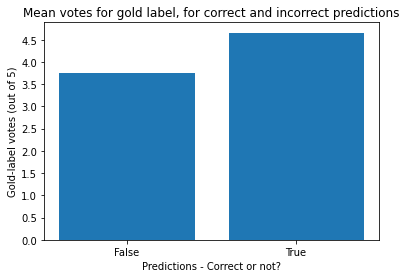

,won_by_2_way
correct_pred_2_way,
False,3.752688
True,4.657691


In [41]:
result = plot_votes_correctness(raw_test_set, 2)
result

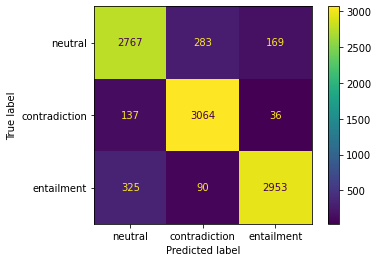

In [42]:
def plot_confusion_matrix(labels, predictions, classes_dict: dict):
    cm = confusion_matrix(labels, predictions, labels=list(classes_dict.values()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes_dict.keys())
    disp.plot()
    plt.show()
    
plot_confusion_matrix(labels, predictions, LABELS)

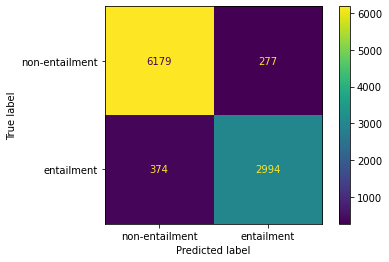

In [43]:
plot_confusion_matrix(labels2, predictions2, {"non-entailment": 0, "entailment": 1})

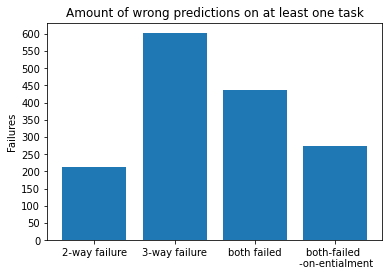

In [44]:
correct3_failed2 = raw_test_set[(raw_test_set["correct_pred_3_way"] == (True)) & (raw_test_set["correct_pred_2_way"] == (False))]
failed3_correct2 = raw_test_set[(raw_test_set["correct_pred_3_way"] == (False)) & (raw_test_set["correct_pred_2_way"] == (True))]
both_failed = raw_test_set[(raw_test_set["correct_pred_3_way"] == (False)) & (raw_test_set["correct_pred_2_way"] == (False))]
both_failed_on_entailment = raw_test_set[(raw_test_set["correct_pred_3_way"] == (False)) & (raw_test_set["correct_pred_2_way"] == (False)) & (raw_test_set["gold_label"] == ("entailment"))]
both_correct = raw_test_set[(raw_test_set["correct_pred_3_way"] == (True)) & (raw_test_set["correct_pred_2_way"] == (True))]

y_axis =[len(correct3_failed2), len(failed3_correct2), len(both_failed), len(both_failed_on_entailment)]
plt.bar(["2-way failure", "3-way failure", "both failed", "both-failed \n -on-entialment"], y_axis)
plt.yticks(np.arange(0, max(y_axis), step=50))
plt.ylabel("Failures")
plt.title("Amount of wrong predictions on at least one task")
plt.show()

We assumed that the length of sentences will influence on the predictions' correctness. <br>
Our assumption seems to be wrong, as we couldn't find a clear distinction between the length of correct predictions and the opposite.

In [45]:
x = both_correct[["sentence1_len", "sentence2_len"]].mean()
y = both_failed[["sentence1_len", "sentence2_len"]].mean()
x, y

(sentence1_len    13.934780
 sentence2_len     7.450356
 dtype: float64,
 sentence1_len    14.474886
 sentence2_len     7.824201
 dtype: float64)

### Taste of the data for error-analysis discussion

#### Both failed

In [46]:
pd.set_option('display.max_colwidth', None)
both_failed[["sentence1", "sentence2", "gold_label", "predictions_2_way", "predictions_3_way"]].head(3)

,sentence1,sentence2,gold_label,predictions_2_way,predictions_3_way
12,A land rover is being driven across a river.,A Land Rover is splashing water as it crosses a river.,entailment,0,1
43,Male in a blue jacket decides to lay in the grass.,The guy wearing a blue jacket is laying on the green grass,entailment,0,0
79,A man looking over a bicycle's rear wheel in the maintenance garage with various tools visible in the background.,A man repairs bicycles.,entailment,0,0


#### 3-failed, 2-correct

In [47]:
failed3_correct2[["sentence1", "sentence2", "gold_label", "predictions_2_way", "predictions_3_way"]].head(3)

,sentence1,sentence2,gold_label,predictions_2_way,predictions_3_way
0,This church choir sings to the masses as they sing joyous songs from the book at a church.,The church has cracks in the ceiling.,neutral,0,1
20,A blond-haired doctor and her African american assistant looking threw new medical manuals.,A doctor is studying,neutral,0,2
23,"One tan girl with a wool hat is running and leaning over an object, while another person in a wool hat is sitting on the ground.",A man watches his daughter leap,neutral,0,1


#### 3-correct, 2-failed

In [48]:
correct3_failed2[["sentence1", "sentence2", "gold_label", "predictions_2_way", "predictions_3_way"]].head(3)

,sentence1,sentence2,gold_label,predictions_2_way,predictions_3_way
4,"A woman with a green headscarf, blue shirt and a very big grin.",The woman is very happy.,entailment,0,2
8,An old man with a package poses in front of an advertisement.,A man walks by an ad.,contradiction,1,1
18,A blond-haired doctor and her African american assistant looking threw new medical manuals.,A doctor is looking at a book,entailment,0,2


#### both correct

In [49]:
both_correct[["sentence1", "sentence2", "gold_label", "predictions_2_way", "predictions_3_way"]].head(3)

,sentence1,sentence2,gold_label,predictions_2_way,predictions_3_way
1,This church choir sings to the masses as they sing joyous songs from the book at a church.,The church is filled with song.,entailment,1,2
2,This church choir sings to the masses as they sing joyous songs from the book at a church.,A choir singing at a baseball game.,contradiction,0,1
3,"A woman with a green headscarf, blue shirt and a very big grin.",The woman is young.,neutral,0,0
